__This notebook shows general evaluation of the DMS and alanine scanning (AS) data collected.__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [3]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Data reading

DMS and AS data were normalised as mentioned in the Method that:
* Contain only single amino acid (alanine) substitution compared to the reference protein sequence
* score to 1 for wildtype-like variants
* score to 0 for nonsense-like variants

The `dataset_info` file contains the experimental information of DMS and AS data.

In [4]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)

# Results

## Score distribution

The code take normalized DMS & AS score to show their distribution, creating __Figure S1__.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

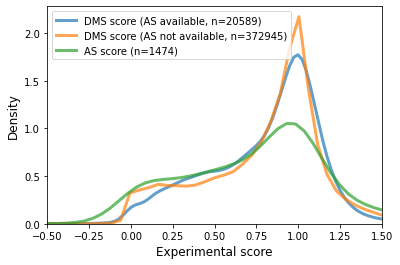

In [4]:
# Identify AS data availability on each DMS variant.
as_covered_res = norm_as[['uniprot_id', 'u_pos']].drop_duplicates()
as_covered_res['AS_available'] = True
as_covered_dms = pd.merge(norm_dms, as_covered_res, on=['uniprot_id', 'u_pos'], how='left', validate='m:1')
as_covered_dms['AS_available'] = as_covered_dms['AS_available'].fillna(False)

fig = plt.figure(figsize=(6,4))
fig.patch.set_facecolor('w')
kde_kws={'lw':3, 'alpha':0.7}
sns.distplot(as_covered_dms[as_covered_dms['AS_available']]['score'], kde_kws=kde_kws, 
             label=f"DMS score (AS available, n={sum(as_covered_dms['AS_available'])})", hist=False)
sns.distplot(as_covered_dms[~as_covered_dms['AS_available']]['score'], kde_kws=kde_kws, 
             label=f"DMS score (AS not available, n={sum(~as_covered_dms['AS_available'])})", hist=False)
sns.distplot(norm_as['AS_score'], kde_kws=kde_kws, label=f'AS score (n={len(norm_as)})', hist=False)
plt.xlim([-0.5, 1.5])
plt.xlabel('Experimental score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

## Data coverage (on going)

### Proposed

The following code calculate the number of AS experiments available for each DMS scanned protein residue.
1. Count number of AS experiments on each protein residue
2. Map the count result to DMS scanned protein residues (adding DMS residues with no AS data available)
3. Reformat data for visualisation

In [5]:
# Calculate AS experiments available on each protein residue.
prores_as_count = norm_as[['uniprot_id', 'u_pos', 'AS_score']].groupby(['uniprot_id', 'u_pos'], 
                                                                       as_index=False).count()
prores_as_count = prores_as_count.rename(columns={'AS_score': 'AS_count'})
prores_as_count.loc[prores_as_count['AS_count']>=6, 'AS_count'] = '≥6'  # Set upper bound.

# Map to residues covered by DMS data.
pro_res_dmscover = norm_dms.groupby(['uniprot_id', 'u_pos'], as_index=False).first()[['uniprot_id', 'u_pos']]
prores_as_count = pd.merge(pro_res_dmscover, prores_as_count, on=['uniprot_id', 'u_pos'], 
                           how='left', validate='1:1').fillna(0)

# Calculate count of protein residues with given number of AS experiments.
res_count = prores_as_count.groupby(['uniprot_id', 'AS_count'], as_index=False).count()
res_count = res_count.pivot(index='uniprot_id', columns='AS_count', values='u_pos').fillna(0)
res_count = res_count.loc[norm_as.uniprot_id.unique()]  # Remove protein without any AS data.
row_order = res_count.iloc[:,1:].sum(axis=1).sort_values(ascending=False).index
col_order = [1, 2, 3, 4, 5, '≥6', 0]
res_count = res_count.loc[row_order, col_order]
res_count.index = res_count.index.map(data_info.groupby('uniprot_id')['protein_name'].first())

Following code are used to create __Figure 2__.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum +

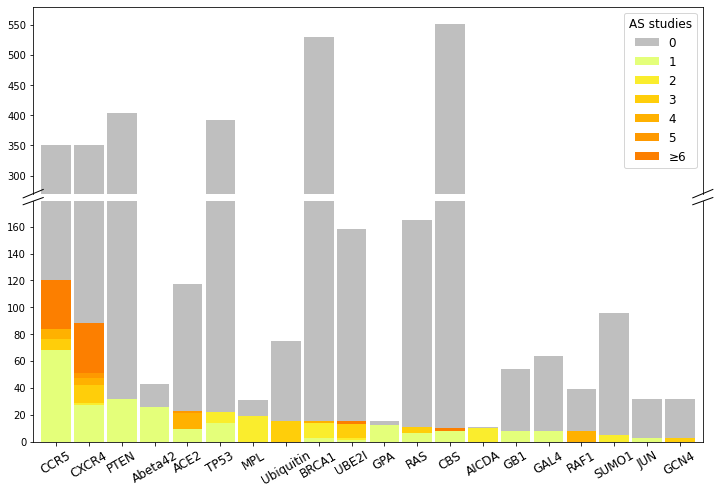

In [6]:
# 1. Set color palette.
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)

# 2. Create main figure.
fig, axs = plt.subplots(2,1,figsize=(12,8),gridspec_kw={'height_ratios':[3.5,4.5]})
fig.patch.set_facecolor('w')
plt.subplots_adjust(hspace=0.035)
for ax in axs:
    res_count.plot(kind='bar', stacked=True, color=hue, width=0.9, ax=ax)
axs[0].set_ylim(270,580)
axs[1].set_ylim(0,179)

# 3. Set legend.
axs[1].legend().remove()
handles, labels = axs[0].get_legend_handles_labels()
legend_order = [6,0,1,2,3,4,5]
axs[0].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc=1, 
              fontsize=12).set_title('AS studies', prop={'size': 12})

# 4. Set spines, ticks and labels.
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_xlabel(None)
axs[1].set_xlabel(None)
axs[0].set_xticks([])
axs[0].set_xticks([], minor=True)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, fontsize=12)

# 5. Add breaking symbol.
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False, linewidth=1)
d = .015  # how big to make the diagonal lines in axes coordinates
adjustor = 1.5
axs[0].plot((-d, +d), (-d*adjustor, +d*adjustor), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d*adjustor, +d*adjustor), **kwargs)  # top-right diagonal
kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

### Formatted data

In [5]:
# How many AS experiments available on each protein residue.
prores_as_count = norm_as[['uniprot_id', 'u_pos', 'AS_score']].groupby(['uniprot_id', 'u_pos'], as_index=False).count()
prores_as_count = prores_as_count.rename(columns={'AS_score': 'AS_count'})

In [6]:
# How many AS experiments available for each DMS scanned residue.
dms_res = norm_dms[['dms_id', 'position', 'uniprot_id', 'u_pos']].groupby(['dms_id', 'position'], as_index=False).first()
dmsres_as_count = pd.merge(dms_res, prores_as_count, on=['uniprot_id', 'u_pos'], how='left', validate='m:1')
dmsres_as_count = dmsres_as_count.sort_values(['uniprot_id', 'u_pos'])
dmsres_as_count['AS_count'] = dmsres_as_count['AS_count'].fillna(0)  # Missing count means 0.
dmsres_as_count = dmsres_as_count[dmsres_as_count.uniprot_id.isin(norm_as.uniprot_id.unique())]  # Remove proteins without available AS data at all.

In [7]:
# How many AS experiments available for each protein (DMS scanned) residue.
pro_res_dmscover = norm_dms[['uniprot_id', 'u_pos', 'score']].groupby(['uniprot_id', 'u_pos'], as_index=False).first()
prores_as_count_dmscover = pd.merge(pro_res_dmscover, prores_as_count, on=['uniprot_id', 'u_pos'], how='left', validate='1:1')
prores_as_count_dmscover = prores_as_count_dmscover.sort_values(['uniprot_id', 'u_pos'])
prores_as_count_dmscover['AS_count'] = prores_as_count_dmscover['AS_count'].fillna(0)  # Missing count means 0.
prores_as_count_dmscover = prores_as_count_dmscover[prores_as_count_dmscover.uniprot_id.isin(norm_as.uniprot_id.unique())]  # Remove proteins without available AS data at all.

### Stack bar

In [8]:
# Number of residues with certain amount of AS experiments for each DMS.
dmsres_as_count_6m = dmsres_as_count.copy()
dmsres_as_count_6m.loc[dmsres_as_count_6m[dmsres_as_count_6m['AS_count']>6].index, 'AS_count'] = 6
dmsres_as_count_6m_dmsgroup = dmsres_as_count_6m.groupby(['dms_id', 'AS_count'], as_index=False).count()[['dms_id', 'AS_count', 'u_pos']]
dmsres_as_count_6m_dmsgroup = dmsres_as_count_6m_dmsgroup.pivot(index='dms_id', columns='AS_count', values='u_pos')
dmsres_as_count_6m_dmsgroup = dmsres_as_count_6m_dmsgroup.rename(columns={6:'≥6'})

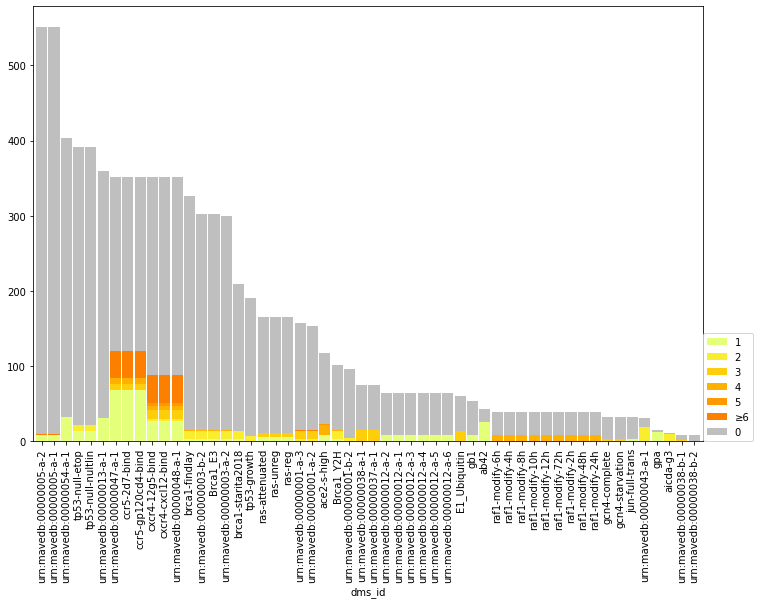

In [125]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
ax = dmsres_as_count_6m_dmsgroup.loc[dmsres_as_count_6m_dmsgroup.sum(axis=1).sort_values(ascending=False).index, 
                                     cols].fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.legend(loc=[1,0])
#ax.set_ylim(0,130)
plt.show()

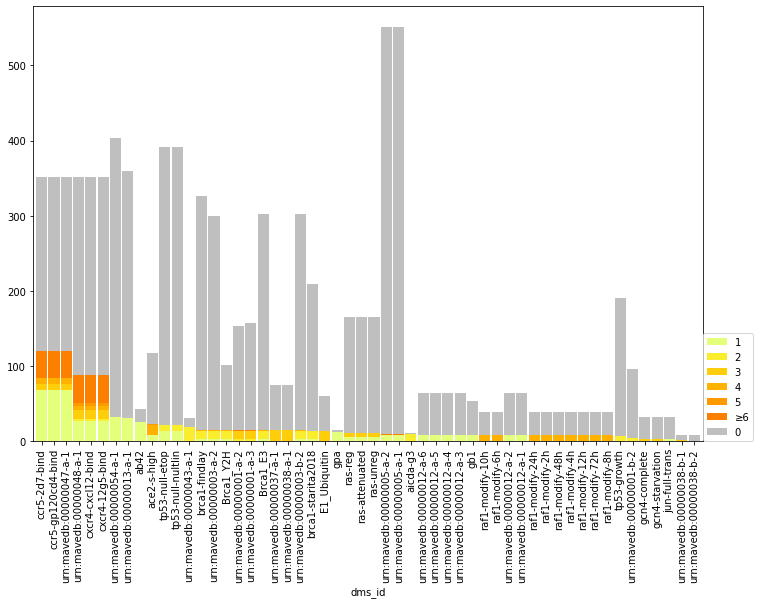

In [124]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
ax = dmsres_as_count_6m_dmsgroup.loc[dmsres_as_count_6m_dmsgroup.iloc[:, 1:].sum(axis=1).sort_values(ascending=False).index, 
                                     cols].fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.legend(loc=[1,0])
#ax.set_ylim(0,130)
plt.show()

In [9]:
# Number of residues with certain amount of AS experiments for each protein.
prores_as_count_dmscover_6m = prores_as_count_dmscover.copy()
prores_as_count_dmscover_6m.loc[prores_as_count_dmscover_6m[prores_as_count_dmscover_6m['AS_count']>6].index, 'AS_count'] = 6
prores_as_count_dmscover_6m_progroup = prores_as_count_dmscover_6m.groupby(['uniprot_id', 'AS_count'], as_index=False).count()[['uniprot_id', 'AS_count', 'u_pos']]
prores_as_count_dmscover_6m_progroup = prores_as_count_dmscover_6m_progroup.pivot(index='uniprot_id', columns='AS_count', values='u_pos')
prores_as_count_dmscover_6m_progroup = prores_as_count_dmscover_6m_progroup.rename(columns={6:'≥6'})

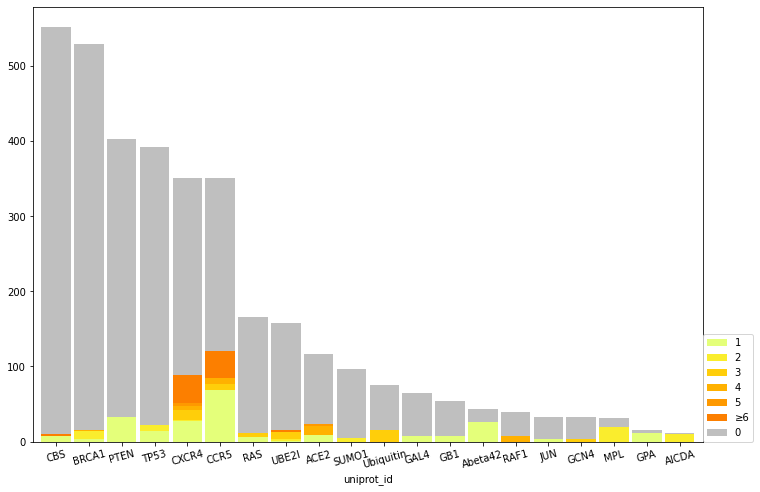

In [58]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
vis_data = prores_as_count_dmscover_6m_progroup.loc[prores_as_count_dmscover_6m_progroup.sum(axis=1).sort_values(ascending=False).index, 
                                                    cols]
vis_data.index = vis_data.index.map(data_info.groupby('uniprot_id')['protein_name'].first())
ax = vis_data.fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.legend(loc=[1,0])
plt.show()

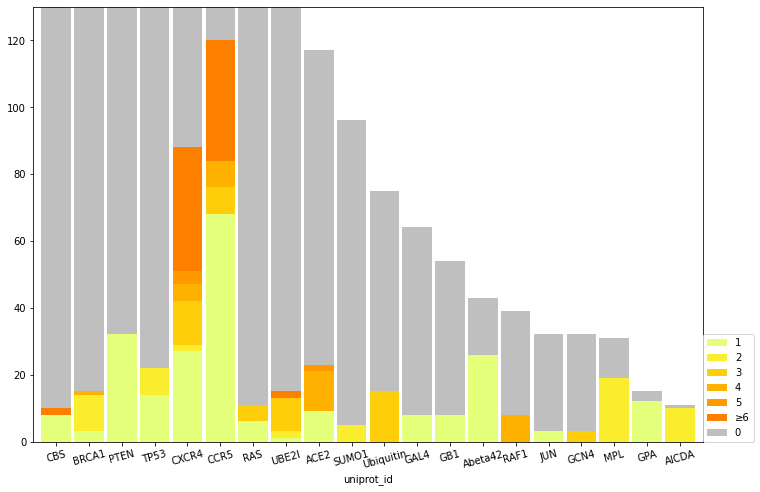

In [62]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
vis_data = prores_as_count_dmscover_6m_progroup.loc[prores_as_count_dmscover_6m_progroup.sum(axis=1).sort_values(ascending=False).index, 
                                                    cols]
vis_data.index = vis_data.index.map(data_info.groupby('uniprot_id')['protein_name'].first())
ax = vis_data.fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.legend(loc=[1,0])
ax.set_ylim(0,130)
plt.show()

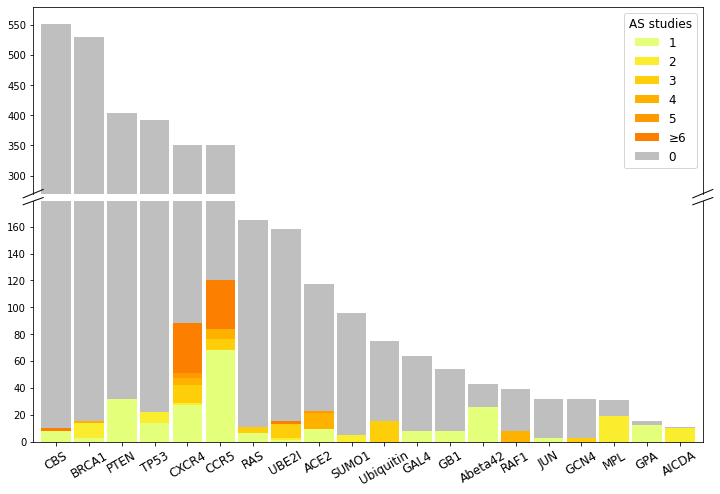

In [156]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
vis_data = prores_as_count_dmscover_6m_progroup.loc[prores_as_count_dmscover_6m_progroup.sum(axis=1).sort_values(ascending=False).index, 
                                                    cols]
vis_data.index = vis_data.index.map(data_info.groupby('uniprot_id')['protein_name'].first())

fig, axs = plt.subplots(2,1,figsize=(12,8),gridspec_kw={'height_ratios':[3.5,4.5]})
fig.patch.set_facecolor('w')
plt.subplots_adjust(hspace=0.035)
for ax in axs:
    vis_data.fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9, ax=ax)
axs[0].set_ylim(270,580)
axs[1].set_ylim(0,179)
axs[1].set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12)
axs[1].legend().remove()
axs[0].legend(loc=1, fontsize=12).set_title('AS studies', prop={'size': 12})
axs[1].set_xlabel('')

# Hide spines, ticks and labels.
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_xlabel(None)
axs[0].set_xticks([])
axs[0].set_xticks([], minor=True)

# Add breaking symbol.
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False, linewidth=1)
d = .015  # how big to make the diagonal lines in axes coordinates
adjustor = 1.5
axs[0].plot((-d, +d), (-d*adjustor, +d*adjustor), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d*adjustor, +d*adjustor), **kwargs)  # top-right diagonal

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

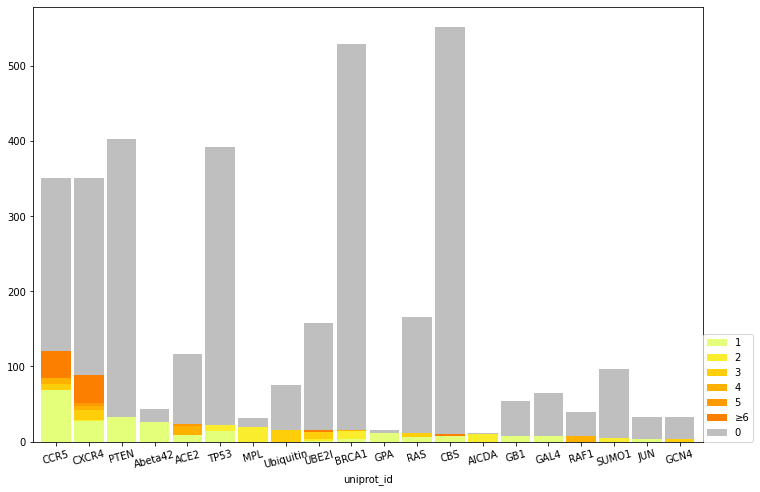

In [61]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
vis_data = prores_as_count_dmscover_6m_progroup.loc[prores_as_count_dmscover_6m_progroup.iloc[:,1:].sum(axis=1).sort_values(ascending=False).index, 
                                                    cols]
vis_data.index = vis_data.index.map(data_info.groupby('uniprot_id')['protein_name'].first())
ax = vis_data.fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.legend(loc=[1,0])
plt.show()

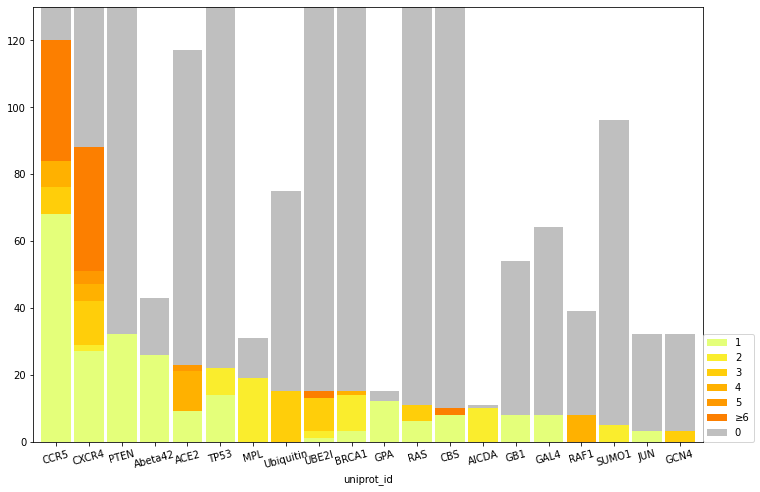

In [60]:
cols = list(np.arange(1,6)) + ['≥6',0]
hue = []
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue.append(cmap(i))
hue.append([0.75]*3)
vis_data = prores_as_count_dmscover_6m_progroup.loc[prores_as_count_dmscover_6m_progroup.iloc[:,1:].sum(axis=1).sort_values(ascending=False).index, 
                                                    cols]
vis_data.index = vis_data.index.map(data_info.groupby('uniprot_id')['protein_name'].first())
ax = vis_data.fillna(0).plot(kind='bar', stacked=True, figsize=(12,8), color=hue, width=0.9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.legend(loc=[1,0])
ax.set_ylim(0,130)
plt.show()

### Percentage coverage

In [ ]:
dms_name_map = data_info.groupby('dms_id').first()['dms_name']
pro_name_map = data_info.groupby('dms_id').first()['protein_name']
row['dms_name'] = dms_name_map[dms]
row['protein_name'] = pro_name_map[dms]

In [ ]:
for index, dms_res in dms_data.iterrows():
    

In [ ]:
vis_data = []
for dms, dms_data in as_cover_dms.groupby('dms_id'):
    row = dict()
    array = np.array(data[dms])
    length = len(array)
    row['size'] = length
    for key in range(1,7):
        if key < 6:
            row[f"{key}_AS"] = (np.where(array == key)[0] + 0.5) / length * 100
        elif key == 6:
            row[f"{key}_AS"] = (np.where(array >= key)[0] + 0.5) / length * 100
        else:
            raise ValueError
    row['start'] = array.nonzero()[0][0] / length * 100
    row['end'] = array.nonzero()[0][-1] / length * 100
    row['coverage'] = len(array.nonzero()[0]) / length * 100
    vis_data = vis_data.append(row)

In [4]:
dms_name_map = data_info.groupby('dms_id').first()['dms_name']
pro_name_map = data_info.groupby('dms_id').first()['protein_name']
vis_data = pd.DataFrame()
for dms, data in dmsa_region.items():
    row = pd.Series(name=dms)
    row['dms_name'] = dms_name_map[dms]
    row['protein_name'] = pro_name_map[dms]
    array = np.array(data[dms])
    length = len(array)
    row['size'] = length
    for key in range(1,7):
        if key < 6:
            row[f"{key}_AS"] = (np.where(array == key)[0] + 0.5) / length * 100
        elif key == 6:
            row[f"{key}_AS"] = (np.where(array >= key)[0] + 0.5) / length * 100
        else:
            raise ValueError
    row['start'] = array.nonzero()[0][0] / length * 100
    row['end'] = array.nonzero()[0][-1] / length * 100
    row['coverage'] = len(array.nonzero()[0]) / length * 100
    vis_data = vis_data.append(row)

from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(30,18))
fig.patch.set_facecolor('w')
total_dms = 54
ax.add_patch(Rectangle((0,0),100,total_dms,facecolor=[0.85]*3, zorder=0))
hue = {}
cmap = plt.cm.get_cmap('Wistia', 6)
for i in range(6):
    hue[i+1] = cmap(i)

foo = vis_data.copy()
foo['protein_high_coverage'] = foo['protein_name'].map(foo.groupby('protein_name')['coverage'].max())
foo = foo.sort_values(['protein_high_coverage','protein_name','coverage'])
i = 0
for dms, row in foo.iterrows():
    y_range = [i, i+1]
    linewidth = 19 * 100 / row['size']  # Bug: line covers left and right region, right part is missing for full scan
    for key, color in hue.items():
        ax.vlines(row[f"{key}_AS"], *y_range, colors=color, zorder=1, lw=linewidth)
    i += 1
ax.hlines(np.arange(total_dms), *ax.get_xlim(), colors='w')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks(np.arange(total_dms)+0.5)
ax.set_yticklabels(foo['dms_name'], fontsize=16)
plt.xlim(0,100)
plt.ylim(0,54)
plt.show()

NameError: name 'DMS_INFO' is not defined

In [10]:
name_map = data_info.groupby('dms_id').first()['dms_name']
dmsa_region = dict()
for dms, foo in dms_all_as.groupby('dms_id'):
    foo = foo[['dmsa_id', 'u_pos', 'Ascan_score_avail']].drop_duplicates()
    bar = foo[['u_pos']].drop_duplicates()
    bar['dmsa_id'] = dms + '@nan'
    bar['Ascan_score_avail'] = False
    foo = foo[foo['Ascan_score_avail']].append(bar)
    vis_data = (foo.groupby('u_pos').count()-1)[['dmsa_id']]
    vis_data.loc[vis_data[vis_data['dmsa_id'] > 5].index, 'dmsa_id'] = 6
    vis_data.columns = [dms]
    dmsa_region[dms] = vis_data
    
order_coverage = DEMASK_NA.groupby('dms_id')['u_pos'].nunique().to_frame(name='dms_n_pos')
order_coverage['uniprot_id'] = order_coverage.index.map(DMS_INFO.groupby('dms_id').first()['uniprot_id'])
order_coverage['prot_n_pos'] = order_coverage['uniprot_id'].map(DEMASK_NA.groupby('uniprot_id')['u_pos'].nunique())
order_coverage = order_coverage.sort_values(['prot_n_pos', 'uniprot_id', 'dms_n_pos'], ascending=False)
order_coverage.index = order_coverage.index.map(name_map)

KeyError: "['dmsa_id', 'Ascan_score_avail'] not in index"

## Score correlation

Following code are used to show the score correlation between each pair of DMS-AS data, creating __Figure 3__.
* The correlation values were calculated between AS scores and DMS scores of alanine substitutions.
* Data pairs with less than 3 alanine substitutions avaialble are removed, to avoid extreme values.

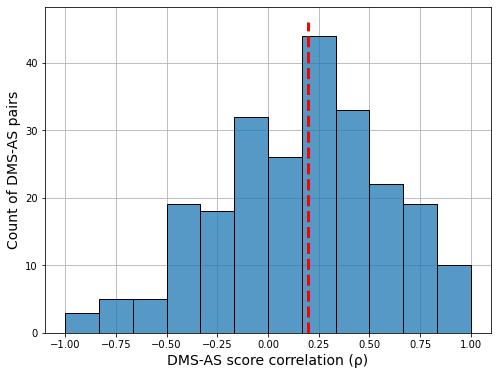

In [7]:
work_data = data_info[['ala_score_correlation', 'n_ala']]
work_data = work_data.dropna().query("n_ala >= 3")  # Data without AS experiments and small ones are removed.

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
fig.patch.set_facecolor('w')
sns.histplot(work_data['ala_score_correlation'], ax=ax, kde=False, zorder=10)
ax.vlines(work_data['ala_score_correlation'].median(),0,46,linestyle='--',colors='r',linewidth=3, zorder=20)
ax.set_ylabel('Count of DMS-AS pairs', fontsize=14)
ax.set_xlabel('DMS-AS score correlation (ρ)', fontsize=14)
ax.grid(zorder=-10)
plt.show()

DMS and AS assay may have different levels of compatibility. 

I manually classified each DMS-AS pair to three levels of assay compatibility: _high_, _medium_ and _low_ which are stored in `data_info`.

Score correlation for data from each level of assay compatibility are shown below, creating __Figure 4.__

The correlation values are calculated and filtered as the above figure.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


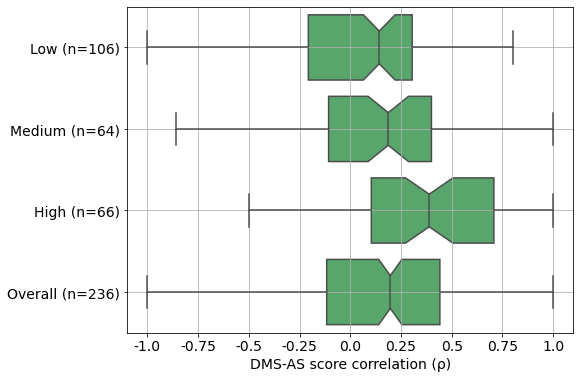

In [8]:
work_data = data_info[['assumed_compatibility', 'ala_score_correlation', 'n_ala']]
work_data = work_data.dropna().query("n_ala >= 3")  # Data without AS experiments and small ones are removed.

# Add overall result.
all_data = work_data.copy()
all_data['assumed_compatibility'] = 'Overall'
work_data = pd.concat([work_data, all_data], ignore_index=True, sort=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('w')
sns.boxplot(y='assumed_compatibility', x='ala_score_correlation', data=work_data, whis=np.inf, notch=True, 
            color=(0.3, 0.7, 0.4, 1.0), orient='h', order=['Low', 'Medium', 'High', 'Overall'],
            ax=ax)
# Add pair counts to tick labels.
yticklabels = [x+' (n='+str(len(work_data.query("assumed_compatibility == @x")))+')' 
               for x in ['Low', 'Medium', 'High', 'Overall']]
ax.set_yticklabels(yticklabels, fontsize=14)
ax.set_xlabel('DMS-AS score correlation (ρ)', fontsize=14)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.grid()
plt.show()

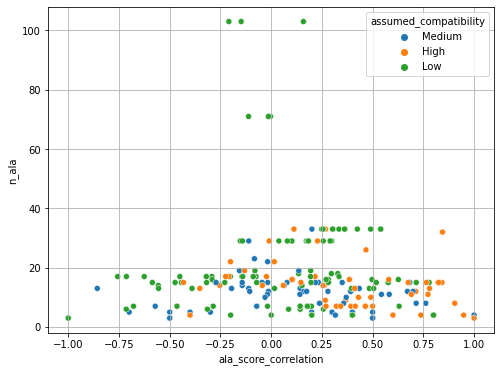

In [9]:
work_data = data_info[['assumed_compatibility', 'ala_score_correlation', 'n_ala']]
work_data = work_data.dropna().query("n_ala >= 3")  # Data without AS experiments and small ones are removed.
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
fig.patch.set_facecolor('w')
sns.scatterplot(data=work_data, x='ala_score_correlation', y='n_ala', ax=ax, hue='assumed_compatibility')
ax.grid(zorder=-10)
plt.show()

## Amino acid count

This section shows the count of each wild-type and variant type amino acid in the curated DMS dataset.

Only variants with available AS data are counted.

In [29]:
def data_aa_count_barplot(count_data, vis_on, xlabel, ticks, xlim, ylim):
    """Visualize amino acid count in bar plot.
    """
    fig = plt.figure(figsize=(14, 2.5))
    fig.patch.set_facecolor('w')
    sns.barplot(x=vis_on, y="count", hue="aa_property", data=count_data, dodge=False)
    plt.xticks(ticks=ticks, label=count_data[vis_on])
    plt.xlabel(xlabel)
    plt.ylabel('Entry count', fontsize=12)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc=1, ncol=5)
    plt.show()

In [16]:
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms, norm_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')
# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

The following code show wild-type & variant type amino acid count for variant entries with available AS experiments:
1. Filter DMS data with available AS result
2. Count and visualize for each wild-type amino acid
3. Count and visualize for each variant type amino acid

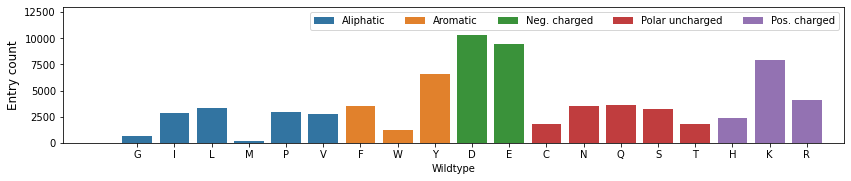

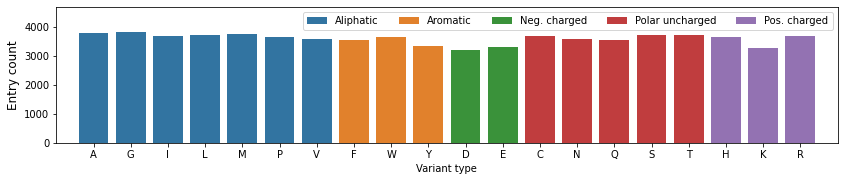

In [30]:
# Select variant data with AS data.
work_data = dms_all_as[dms_all_as['Ascan_score_avail']]

count_data = work_data.groupby('aa1', as_index=False).count()[['score', 'aa1']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa1'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa1'], inplace=True)
data_aa_count_barplot(count_data, 'aa1', 'Wildtype', np.arange(19), [-2,19], [0,13000])

count_data = work_data.groupby('aa2', as_index=False).count()[['score', 'aa2']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa2'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa2'], inplace=True)
data_aa_count_barplot(count_data, 'aa2', 'Variant type', np.arange(20), [-1,20], [0,4700])

The following code show wild-type & variant type amino acid count for variant entries with __highly compatible__ AS experiments, creating __Figure S7__:
1. Filter DMS data with AS result of __high assay compatibility__
2. Count and visualize for each wild-type amino acid
3. Count and visualize for each variant type amino acid

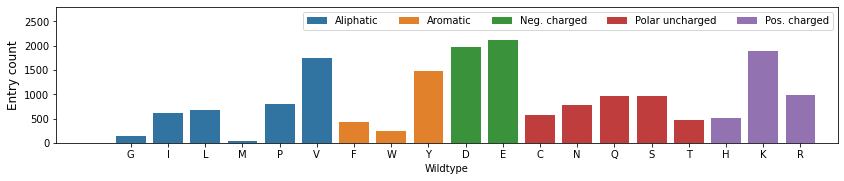

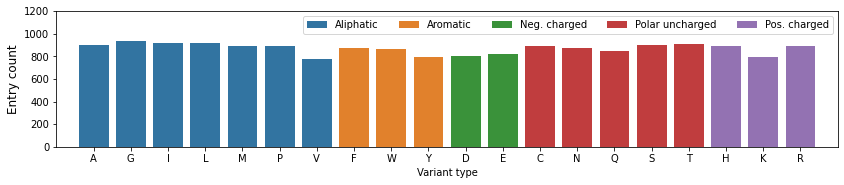

In [31]:
# Select variant data with compatibility filtered AS data.
comp_filter_dmsa = data_info.query("assumed_compatibility == 'High'")['dmsa_id']
work_data = dms_all_as.query("dmsa_id in @comp_filter_dmsa")

count_data = work_data.groupby('aa1', as_index=False).count()[['score', 'aa1']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa1'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa1'], inplace=True)
data_aa_count_barplot(count_data, 'aa1', 'Wildtype', np.arange(19), [-2,19], [0,2800])

count_data = work_data.groupby('aa2', as_index=False).count()[['score', 'aa2']].rename(columns={'score':'count'})
count_data['aa_property'] = count_data['aa2'].map(AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa2'], inplace=True)
data_aa_count_barplot(count_data, 'aa2', 'Variant type', np.arange(20), [-1,20], [0,1200])